***Sam Cressman Capstone Project: Shelter Animal Outcomes***

***Help improve outcomes for shelter animals***

***Capstone inspiration:*** [Kaggle](https://www.kaggle.com/c/shelter-animal-outcomes)

[Intake data (pulled 6/25/18)](https://data.austintexas.gov/Health-and-Community-Services/Austin-Animal-Center-Intakes/wter-evkm) <br>
[Outcome data (pulled 6/25/18)](https://data.austintexas.gov/Health-and-Community-Services/Austin-Animal-Center-Outcomes/9t4d-g238) <br>

"Annually over 90% of animals entering the center, are adopted, transferred to rescue or returned to their owners. The Outcomes data set reflects that Austin, TX. is the largest "No Kill" city in the country." ([link](https://data.austintexas.gov/Health-and-Community-Services/Austin-Animal-Center-Outcomes/9t4d-g238))

***Modeling Notebook***

In [124]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from keras.models import Sequential
from keras.layers import Dense
from keras.utils import to_categorical
import matplotlib.pyplot as plt

In [125]:
animals = pd.read_csv("../CSVs/cleaned_animals_numeric_dummies.csv")

In [126]:
# Evaluating target

animals["Outcome Type"].value_counts();

In [127]:
# Baseline accuracy is high: 90%

animals["Outcome Type"].value_counts(normalize = True);

***Setting X, y, features***

In [128]:
# Disregarding DateTime objects, target (Outcome Type), Outcome Subtype (many nulls: kept for EDA/visualization),
# Breed (added columns "manually"), Color (created buckets, concated back with animals)

features_to_disregard = ["Intake Time", "Outcome Time", "Date of Birth",
                         "Outcome Type", "Outcome Subtype", "Breed", "Color"]

In [129]:
# Outcome type: 1 if "Transfer", "Adoption", or "Return to Owner"
# 0 if "Euthanasia" or "Other" ("Died", "Disposal", "Missing", "Relocate")("Other" represented about 1.5% of all outcomes)

features = [feat for feat in animals.columns if feat not in features_to_disregard]

X = animals[features]
y = animals["Outcome Type"]

X_train, X_test, y_train, y_test = train_test_split(X, y)

***Logistic Regression Model***

In [130]:
# Accuracy score: 0.7196227014996556 when using 9 classes, 0.9582413311900514 when using binary classification

lr = LogisticRegression()

ss = StandardScaler()
ss.fit(X_train)
X_train = ss.transform(X_train)
X_test = ss.transform(X_test)

model = lr.fit(X_train, y_train)

# Performs very well on training data

model.score(X_train, y_train)

0.9594601755842505

In [131]:
# Also performs very well on testing data

model.score(X_test, y_test)

0.954003497429919

In [132]:
# Confusion Matrix 

# Model is very accurate but overpredicting positive outcomes (due to high baseline accuracy)

y_pred = model.predict(X_test)

tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

print("True Negatives: " + str(tn))
print()
print("False Positives: " + str(fp))
print()
print("False Negatives: " + str(fn))
print()
print("True Positives: " + str(tp))

True Negatives: 1209

False Positives: 749

False Negatives: 119

True Positives: 16794


In [133]:
# Creating DataFrame to view coefficient values

coef_df = pd.DataFrame({
        "coef": model.coef_[0],
        "feature": features})

In [134]:
# Helping to interpret coefficients

coef_df["exponential_value"] = [(np.exp(i)) for i in coef_df["coef"]]

In [135]:
# Examining top features: this makes sense!

coef_df.sort_values("coef", ascending = False).head(15);

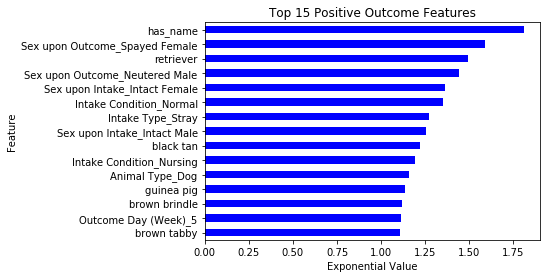

In [136]:
# Plotting top features

coef_features_top = coef_df.sort_values("exponential_value", ascending = False).head(15)

coef_features_top = coef_features_top.sort_values("exponential_value", ascending = True)

coef_features_top.plot(kind = "barh", x = "feature", y = "exponential_value", legend = False, color = "blue")

plt.title("Top 15 Positive Outcome Features")
plt.xlabel("Exponential Value")
plt.ylabel("Feature")

plt.show()

In [137]:
# Examining bottom features: this also makes sense!

coef_df.sort_values("coef", ascending = False).tail(15);

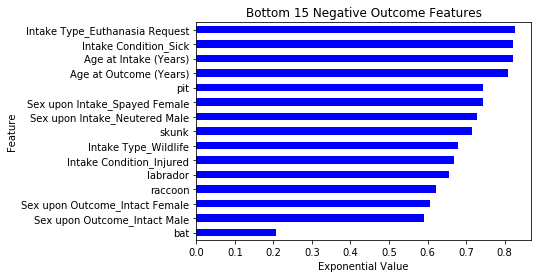

In [139]:
# Plotting bottom features

coef_features_bottom = coef_df.sort_values("exponential_value", ascending = False).tail(15)

coef_features_bottom = coef_features_bottom.sort_values("exponential_value", ascending = True)

coef_features_bottom.plot(kind = "barh", x = "feature", y = "exponential_value", legend = False, color = "blue")

plt.title("Bottom 15 Negative Outcome Features")
plt.xlabel("Exponential Value")
plt.ylabel("Feature")

plt.show()

***Random Forest***

In [57]:
# Simple Random Forest performed very well: 6% over baseline which is high to begin with

# Black box: limited/no interpretability

rf = RandomForestClassifier()

rf.fit(X_train, y_train)

rf.score(X_test, y_test)

0.9622171586031477

***Neural Network***

Neural networks, in a single line, attempt to iteratively train a set (or sets) of weights that, when used together, return the most accurate predictions for a set of inputs. The model is trained using a loss function, which our model will attempt to minimize over iterations.

In [58]:
X_train, X_test, y_train, y_test = train_test_split(X, y)

ss = StandardScaler()
X_train = ss.fit_transform(X_train)
X_test = ss.transform(X_test)

In [59]:
# One hot encoding target

y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

In [60]:
# Need shape to help create neural network

X_train.shape;

In [61]:
# Performs extremely well but black box: no interpretability

model = Sequential()

model.add(Dense(246, input_dim = 246, activation= "relu"))
model.add(Dense(2, activation = "softmax"))

model.compile(loss = "binary_crossentropy", optimizer = "adam", metrics = ["accuracy"])

model.fit(X_train, y_train, validation_data = (X_test, y_test), epochs = 10)

Train on 56611 samples, validate on 18871 samples
Epoch 1/10
56611/56611 [==============================] - 6s 112us/step - loss: 0.1509 - acc: 0.9534 - val_loss: 0.1380 - val_acc: 0.9575
Epoch 2/10
56611/56611 [==============================] - 6s 102us/step - loss: 0.1200 - acc: 0.9617 - val_loss: 0.1384 - val_acc: 0.9574
Epoch 3/10
56611/56611 [==============================] - 6s 100us/step - loss: 0.1086 - acc: 0.9644 - val_loss: 0.1425 - val_acc: 0.9561
Epoch 4/10
56611/56611 [==============================] - 6s 102us/step - loss: 0.0956 - acc: 0.9664 - val_loss: 0.1472 - val_acc: 0.9564
Epoch 5/10
56611/56611 [==============================] - 6s 114us/step - loss: 0.0812 - acc: 0.9709 - val_loss: 0.1574 - val_acc: 0.9543
Epoch 6/10
56611/56611 [==============================] - 6s 109us/step - loss: 0.0664 - acc: 0.9765 - val_loss: 0.1795 - val_acc: 0.9562
Epoch 7/10
56611/56611 [==============================] - 6s 105us/step - loss: 0.0551 - acc: 0.9797 - val_loss: 0.1891 - 